## Описание

Проводится обработка спектров газоразрядной лампы. Выполняется выделение полезного сигнала в области 120-200 нм.

При измерених спектрометром AGS получаем изображения спектра в виде изображений 2048*512 пикселей в формате .sif. В том же файле как фон записывается спектр с минимальной экспозицией (открывается в отдельном окне), который позволяет определить координаты центра нулевого порадка дифракции.

Файлы .sif можно открывать с помощью ImageJ при наличии соответствующего плагина. Для обработки в Python удобно сначала перевести файл в формат .csv (с помощью того же ImageJ). Таким образом, для каждого .sif файла в исходной папке появятся два файла .csv.

Также используется спектр с выключенной лампой (ещё один .csv файл). Он нужен для того, чтобы вычесть фон от непрерывных внешних источников и темновой ток.

## Используемые библиотеки

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import mean
from scipy.signal import medfilt
from scipy.signal import argrelextrema
import scipy

%matplotlib inline

In [2]:
def get_profile(z0, p01, p02): 

    # get profile of signal from the image
    # input: z0 - 2D-array (2048*512), p01 - upper frontier, p02 - lower frontier
    # output: 1D - array
    
    l = np.shape(z0)[1]
    zy0 = np.array([0]*l)
    for i in range(p01, p02):
        zy0 = zy0 + z0[i]
    return zy0

def rescale(x, y, value):
    # linear approx of value between two dots for rescaling of axis
    # input: x - constant 1D-array; y - 1D-array for rescaling
    # output: rescaled 1D-array

    x = np.asarray(x)
    y = np.asarray(y)
    arra = (x[x < value])
    arrb = (x[x > value])
    a = arra[len(arra)-1]
    b = arrb[0]
    y1 = y[np.where(x == a)]
    y2 = y[np.where(x == b)]
    k = (y1 - y2)/(a - b)
    c = (y1*b - y2*a)/(b - a)
    return k*value + c

## Пример спектра до обработки

Спектр без фильтра БС4 и тот же спектр с минимальной экспозицией:

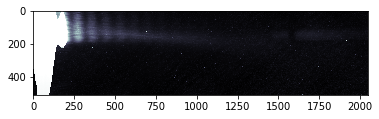

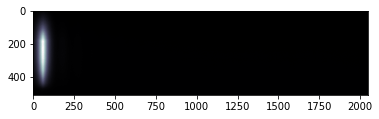

In [3]:
no_bs4 = '0_Xe1Ar24.8_spectra.csv'          # file names
no_bs4_center = '0_Xe1Ar24.8_center.csv'    #

znbs = (np.genfromtxt(no_bs4, delimiter=',',dtype=int, skip_header = 1, usecols = range(1,2049)))         # scanning 2D arrays 
cnbs = (np.genfromtxt(no_bs4_center, delimiter=',',dtype=int, skip_header = 1, usecols = range(1,2049)))  #

plt.bone()         # image style

plt.imshow(znbs)   
plt.show()         # show image

plt.imshow(cnbs)
plt.show()         # show image

Спектр с фильтром БС4 и тот же спектр с минимальной экспозицией:

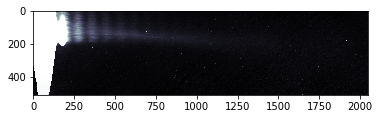

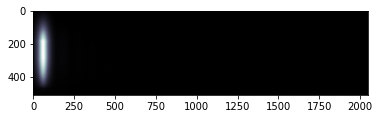

In [4]:
bs4 = '0_BS4Xe1Ar24.8_spectra.csv'        # file names
bs4_center = '0_BS4Xe1Ar24.8_center.csv'

zbs = (np.genfromtxt(bs4, delimiter=',',dtype=int, skip_header = 1, usecols = range(1,2049)))          # scanning 2D arrays
cbs = (np.genfromtxt(bs4_center, delimiter=',',dtype=int, skip_header = 1, usecols = range(1,2049)))

plt.bone()       # image style

plt.imshow(zbs)
plt.show()       # show image

plt.imshow(cbs)
plt.show()       # show image

Спектр с выключенной лампой.

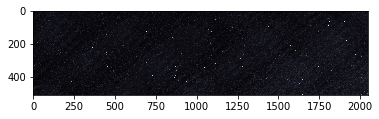

In [5]:
NoLaser = '1_NoLaser.csv'

background = (np.genfromtxt(NoLaser, delimiter=',',dtype=int, skip_header = 1, usecols = range(1,2049)))

plt.bone()
plt.imshow(background)
plt.show()

## Медианная фильтрация

На спектрах видны неисправные пиксели - отдельные белые точки в тёмных областях. Их можно убрать с помощью медианного фильтра (https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D0%B4%D0%B8%D0%B0%D0%BD%D0%BD%D1%8B%D0%B9_%D1%84%D0%B8%D0%BB%D1%8C%D1%82%D1%80).

Размер окна фильтра выбирается как минимальное необходимое число пикселей, чтобы убрать импульсные помехи - белые точки. В данном случае размер окна равен 5 пикселям, сам фильтр применяется дважды.

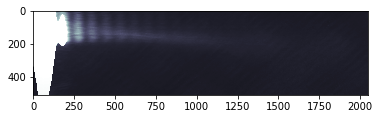

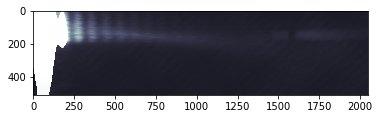

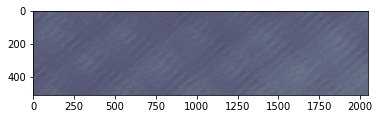

In [6]:
pixels = 5                                 # set median filter window size (in pixels)
zbs = medfilt(zbs, pixels)                 # use median filter for spectrum with BS4 for the first time
znbs = medfilt(znbs, pixels)               # use median filter for spectrum without BS4 for the first time
background = medfilt(background, pixels)   # use median filter for background for the first time

zbs = medfilt(zbs, pixels)                 # use median filter for spectrum with BS4 for the second time
znbs = medfilt(znbs, pixels)               # use median filter for spectrum without BS4 for the second time
background = medfilt(background, pixels)   # use median filter for background for the second time

plt.bone()

plt.imshow(zbs)
plt.show()

plt.imshow(znbs)
plt.show()

plt.imshow(background)
plt.show()                 # show images

## Определение координат центра нулевого порядка дифракции

Интенсивность в нулевом порядке дифракции сильно зависит от координаты, поэтому удобно рассматривать логарифм от интенсивности. К тому же числа большие и целые (int), поэтому при суммировании могут возникнуть пробелемы около числа 2147483647, взятие логарифма также решает эту проблему. Сразу же выделим только нулевой порядок (самое яркое пятно).

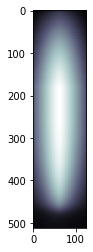

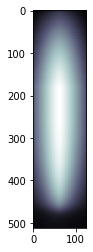

In [7]:
cnbs = np.log(cnbs[:, 0:125])      # set region with zero order for spectrum without BS4
cbs = np.log(cbs[:, 0:125])        # set region with zero order for spectrum with BS4

plt.imshow(cnbs)
plt.show()

plt.imshow(cnbs)
plt.show()                         # show images

Центр пятна вычисляется аналогично центру масс системы материальных точек. (https://ru.wikipedia.org/w/index.php?title=%D0%A6%D0%B5%D0%BD%D1%82%D1%80_%D0%BC%D0%B0%D1%81%D1%81&oldid=103174518)

Центры пятен c фильтром БС4 и без него могут не совпадать. Это вызвано тем, что при установке фильтра в закрытой камере сложно поставить его строго перпендикулярно лучу свет, следовательно, изображение немного смещается. Поэтому вычислим вектор разности радиус-векторов центров.

In [8]:
s1 = 0                                      # tmp1
s2 = 0                                      # tmp2

for i in range(len(cnbs)):                  # sum for all pixel in 2D-image
    for j in range(len(cnbs[0])):
        s1 += cnbs[i][j]*np.array([i, j])   # value multiplied by radius vector
        s2 += cnbs[i][j]                    # value
s1nbs = s1/s2                               # radius vector of the center
print("NO BS4 center - ",s1nbs)

s1 = 0
s2 = 0
for i in range(len(cbs)):                   # sum for all pixel in 2D-image
    for j in range(len(cbs[0])):
        s1 += cbs[i][j]*np.array([i, j])    # value multiplied by radius vector
        s2 += cbs[i][j]                     # value
s1bs = s1/s2                                # radius vector of the center
print("BS4 center - ", s1bs)
r = s1nbs-s1bs                              # difference between radius vectors of the centers
print("r1-r2 = ", r)

NO BS4 center -  [253.76100552  61.73207965]
BS4 center -  [254.14584294  61.93131218]
r1-r2 =  [-0.38483742 -0.19923253]


## Функция вычитания со сдвигом двух спектров.

In [9]:
def subtract(u0, v0, r0, k):
    # subtraction of one spectrum from another with a shift by a given vector and with a given coefficient
    # input: u0 - spectrum from which to subtract; v0 - spectrum which is subtracted;
    #        r0 - difference between radius vectors of the centers; k - subtraction coefficient
    # output: 2D-array result spectrum

    r = np.round(r0)                              # round to integers
    
    if r[0] == 0:                                 # zero shift
        pass
    elif r[0] > 0:                                # positive direction of the shift 
        u0 = u0[:, int(r[0]):]
        v0 = v0[:, :len(v0[0])-int(r[0])]
    else:                                         # negative direction of the shift
        v0 = v0[:, int(r[0]):]
        u0 = u0[:, :len(u0[0])-np.abs(int(r[0]))]

    if r[1] == 0:                                 # zero shift
        pass
    elif r[1] > 0:                                # positive direction of the shift
        u0 = u0[:len(u0)-int(r[1]), :]
        v0 = v0[int(r[1]):, :]
    else:                                         # negative direction of the shift
        u0 = u0[int(r[1]):, :]
        v0 = v0[:len(v0)-np.abs(int(r[1])), :]
        
    return u0 - k*v0

## Вычитание сигнала от непрерывных внешних источников (background)

Вычтем фон из спектра без БС4. Коэффициент вычитания выбирается визуально, так чтобы уменьшить "рябь" в спектре. Для этого используется бесконечный цикл, который в конце каждой итерации спрашивает нужна ли ещё одна итерация. Для примера показан нужный коэффициент, коэффициент чуть больше и чуть меньше. Также будем смотреть только на часть спектра с нужным сигналом, то есть правее 1000-го пикселя.

Enter a: 0.4
a =  0.30000000000000004  : 


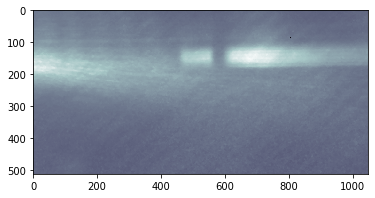

a =  0.4  : 


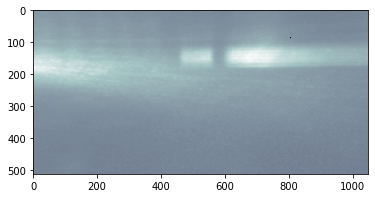

a =  0.5  : 


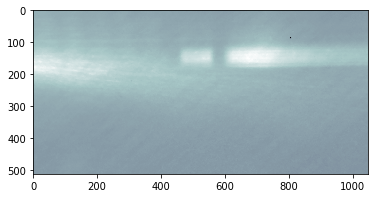

Change coefficient a? (y/n)n


In [10]:
while True:
    a = float(input("Enter a: "))                 # enter approximate coefficient
    lstk = [a-0.1, a, a+0.1]                      # array of coefficients
    for x in lstk:
        zzz = subtract(znbs, background, r*0, x)  # subtract backround
        print('a = ', x, " : ")
        plt.imshow(zzz[:, 1000:])
        plt.show()
    yn = input("Change coefficient a? (y/n)")
    if yn == 'n':
        break
    else:
        plt.clf()
        continue

Аналогично для спектра с фильтром БС4. В этом случае, очевидно, не будет сигнала кроме засветки от нулевого порядка, но backround всё равно нужно вычеть и убрать "рябь".

Enter b: 0.4
b =  0.30000000000000004  : 


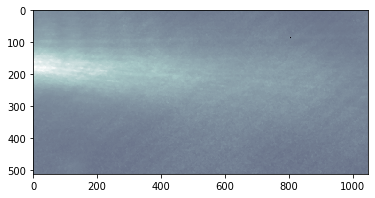

b =  0.4  : 


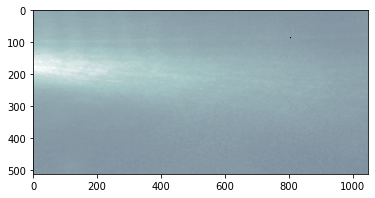

b =  0.5  : 


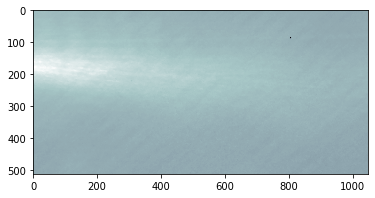

Change coefficient b? (y/n)n


In [11]:
while True:
    b = float(input("Enter b: "))
    lstk = [b-0.1, b, b+0.1]
    for x in lstk:
        zzz = subtract(zbs, background, -1*r*0, x)
        print('b = ', x, " : ")
        plt.imshow(zzz[:, 1000:])
        plt.show()
    yn = input("Change coefficient b? (y/n)")
    if yn == 'n':
        break
    else:
        plt.clf()
        continue

In [12]:
znbs = subtract(znbs, background, r*0, a)
zbs = subtract(zbs, background, r*0, b)

## Вычитание спектров с БС4 и без.

Чтобы найти коэффициент опять же используется бесконечный цикл. Теперь можно ориентироваться не только на "чистоту" изображения, но и на профиль сигнала - его средняя часть должна быть плоской (поскольку из физических соображений там нулевой сигнал). 

Enter c: 1.08
c =  1.08  : 


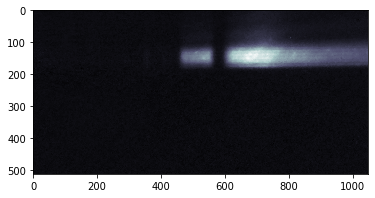

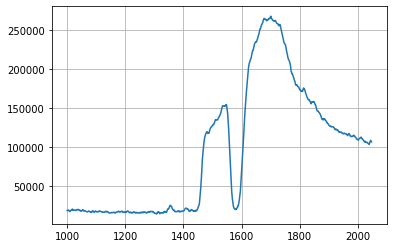

Change coefficient c? (y/n)n


In [13]:
while True:
    c = float(input("Enter c: "))                              # enter approximate coefficient
    print('c = ', c, " : ")
    
    z = subtract(znbs, zbs, r, c)                              # subtract spectrum
    plt.imshow(z[:, 1000:])
    plt.show()
    
    plt.grid('True')
    profile = get_profile(z, 115, 175)
    plt.plot([i for i in range(1000, 2048)], profile[1000:])   # plot profile
    plt.show()
    
    yn = input("Change coefficient c? (y/n)")
    if yn == 'n':
        break
    else:
        plt.clf()
        continue

Спектр сдвинут по оси ординат относительно нуля на константу. Из физических соображений (в коротковолновой области спектр должен отсутствовать из-за того, что выходные окна лампы его не пропускают) получаем, что нужно вычислить среднее значение с 1000-го по 1200-ый пиксель и вычесть из профиля сигнала.

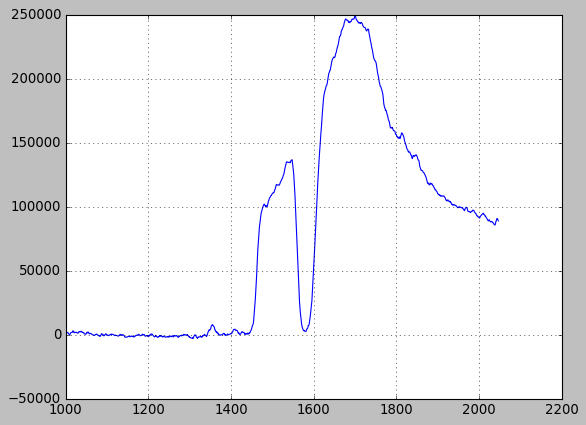

In [14]:
profile = profile[1000:] - mean(profile[1000:1200])     # set zero on y axis

plt.style.use('classic')   # set plot style
plt.grid(True)

x_pix = np.array([i for i in range(1000, 2048)])

plt.plot(x_pix, profile)
plt.show()

Далее необходимо перевести пиксели на оси икс в длины волн (в нм). Для этого проводился дополнительный экперимент с лёгкими элементами (литий, углерод, бор и т.д). В результате получена дисперсионная кривая - зависимость номера пикселя от длины волны, она также аппроксимирована полиномом второй степени.

a =  0.00032318873306211494
b =  0.4106889152295416
c =  -26.017606690411657


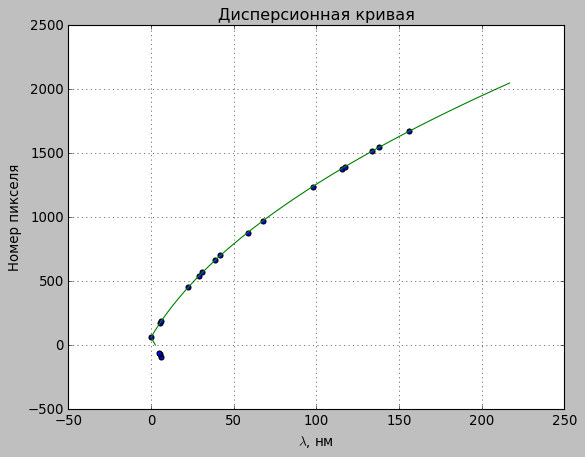

<Figure size 640x480 with 0 Axes>

In [15]:
lmbd = np.array([-6.031439999999999892e-03,-5.268530000000000435e-03,-5.043470000000000418e-03,-0.000000000000000000e+00,5.268530000000000435e-03,6.031439999999999892e-03,2.227909999999999960e-02,2.884230000000000127e-02,3.101696999999999788e-02,3.862028000000000683e-02,4.197139999999999899e-02,5.852609999999999757e-02,6.770040000000000779e-02,9.770199999999999718e-02,1.155129000000000017e-01,1.175263000000000002e-01,1.335707700000000053e-01,1.378386000000000056e-01,1.557300000000000073e-01])
pix = np.array([-9.321443225391274723e+01,-7.123652074274514234e+01,-6.492369513300829453e+01,6.099999999999851497e+01,1.709236259587088114e+02,1.855665828780434765e+02,4.499526144375842591e+02,5.394985903600336314e+02,5.676629885467409622e+02,6.612426867263220629e+02,7.003766898728409842e+02,8.788640245984018975e+02,9.693004356698887705e+02,1.235542468163548619e+03,1.377825532358225246e+03,1.393329496528388972e+03,1.513247608384466957e+03,1.544148932815283843e+03,1.669722633223763751e+03])
# array of pixels and corresponding wavelenghts

lmbd = lmbd*10000  # set micrometers

def line_(x, a, b, c):
    return a*x**2+b*x+c

popt_line, pcov_line = scipy.optimize.curve_fit(line_, pix, lmbd)     # optimize

plt.scatter(np.sign(lmbd)*lmbd/10, pix)                               # plot with nanometers

pix = np.array([i for i in range(2048)])

plt.plot(np.sign(line_(pix, popt_line[0], popt_line[1], popt_line[2]))*0.1*line_(pix, popt_line[0], popt_line[1], popt_line[2]), pix, 'g')
                                                                      # plot line
a = popt_line[0]
b = popt_line[1]
c = popt_line[2]

print("a = ", a)
print("b = ", b)
print("c = ", c)

plt.xlabel('$\lambda$, нм')
plt.ylabel('Номер пикселя')
plt.title("Дисперсионная кривая")
plt.grid('True')
plt.show()
plt.clf()

In [16]:
x_lambda = a/10*x_pix**2 + b/10*x_pix + c/10 + 5 # set x axis (divide by 10 to get nma0
dx = b+2*a*x_lambda                              # derivative

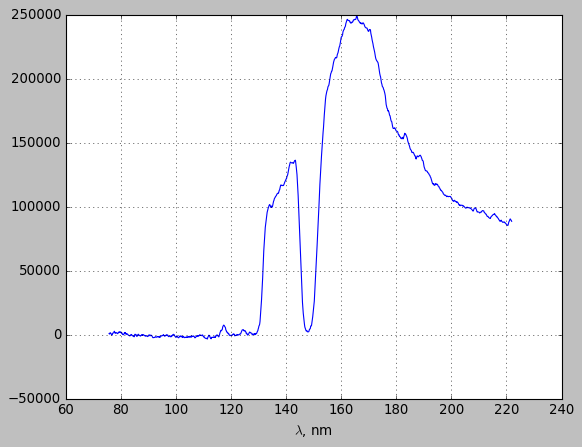

In [17]:
plt.style.use('classic')   # set plot style
plt.grid(True)

plt.plot(x_lambda, profile)
plt.xlabel('$\lambda$, nm')
plt.show()

## Преобразование оси ординат в энергетические единицы

Когда фотон падает на пиксель матрицы, он поглощается и рождает некоторое количество электронов. Затем заряд преобразуется в напряжение, которое в свою очередь преобразуется в числовые значения с помощью АЦП.

Количество электронов, родившихся в одном пикселе матрицы за время экспозиции:
\begin{eqnarray}
	N_{e^-} = counts \cdot G, 
\end{eqnarray}
где $counts$ - число отсчётов АЦП, $G$ - число электронов на один отсчёт АЦП.

Считаем, что все электроны в пикселе рождены монохроматическим светом, то есть свет пространственно разделён по длинам волн и произведено вычитание фона, тогда для числа пришедших фотонов верно:
\begin{eqnarray}
	N_{h\nu} = \frac{N_{e^-}}{\frac{e^-}{ph}(\lambda)},
\end{eqnarray}
где $\frac{e^-}{ph}(\lambda)$ - среднее чичло электронов, рожденных фотоном с длиной волны $\lambda$:
\begin{eqnarray}
	\frac{e^-}{ph}(\lambda) = QE\left( E(\lambda)\right) \cdot \frac{h\nu[J]}{5.81\cdot10^{-19}[J]},
\end{eqnarray}
где $QE$ - квантовая эффективность, определяемая матрицей.

<img src="QE.png" width="400">

Суммарная энергия фотонов с длиной волны $\lambda$, пришедших на пиксель матрицы:
\begin{eqnarray}
	E_{pix}(\lambda) = N_{h\nu}(\lambda)\cdot h\nu = \frac{counts(pix)\cdot G \cdot 5.81\cdot10^{-19[J]}}{QE\left( E(\lambda)\right)}
\end{eqnarray}

Часть энергии поглощается, когда свет падает на дифракционную решетку. Поэтому чтобы охарактеризовать источник излучения необходимо разделить измеренную энергию на коэффициент отражения $R(\lambda)$.

<img src="R.png" width="400">

Теперь необходимо перейти от $counts(pix)$ к $counts(\lambda)$. Это спектральные величины, поэтому преобразование должно сохранять полный интеграл, то есть должно выполняться следующее:
\begin{eqnarray}
	counts(pix)d(pix) = counts(\lambda)d\lambda \\
	counts(\lambda) = counts(pix)\frac{1}{\left(\frac{d\lambda}{d(pix)}\right)}
\end{eqnarray}

Пусть $l_1, l_2$ - расстояния от источника до пространственной щели и щели спектрометра сооветственно, а $d_1, d_2$ - их ширины. Телесный угол в данном эксперименте определяется следующим образом:
\begin{eqnarray}
	d\Omega = d\alpha d\beta = \frac{d_1}{l_1}\cdot\frac{d_2}{l_2}
\end{eqnarray}

Общая формула для пересчёта исходных данных в энергетические единицы:
\begin{eqnarray}
	\frac{dE}{d\Omega d\lambda}(\lambda) = \sum_{pix_y} \frac{d\lambda}{dpix} \cdot \frac{counts(pix_x(\lambda), pix_y)}{R(\lambda) \cdot QE\left( E(\lambda)\right)}\cdot G \cdot 5.81\cdot10^{-19}[J] \cdot \frac{L_1}{d_1}\cdot\frac{L_2}{d_2}
\end{eqnarray}

Для определения спектральной яркости непрерывного источника следует считать энергию в единицу времени на единицу площади:
\begin{eqnarray}
	B_{\lambda} = \frac{dE}{d\Omega d\lambda dt ds}(\lambda),
\end{eqnarray}
где в качестве $ds$ берётся прямоугольник длиной в один пиксель и высотой в количество пикселей, равное размеру изображения источника для данной длины волны.

При измерениях с непрерывным лазером количество пробоев и их величины являются случайными, поэтому для сравнения необходимо провести нормировку. Проведём следующие рассуждения: пусть у нас есть распределение световых импульсов по энергии для конкретного измерения (таким образом, уже известно количество пробоев $N$); из них небольшая часть достигает энергии близкой к максимально возможной в эксперименте при данных параметрах, так получается когда пробой происходит в самом начале лазерного импульса; поэтому будем нормировать спектр так, как-будто он получен только импульсами с максимальной энергией. Учитывая, что полная энергия должна сохраняться, вычислим долю эффективных импульсов:
\begin{eqnarray}
	N_{eff}\cdot E_{max} = N\cdot <E>,\\
	\frac{N_{eff}}{N} = \frac{<E>}{E_{max}},
\end{eqnarray}
где $<E>$ и $E_{max}$ - средняя и максимальная энергия импульса соответственно.
https://github.com/numbersixvs/Light_pulse

Таком образом, получаем формулу для спектральной плотности мощности яркости при оптическом пробое:
\begin{eqnarray}
	B_{\lambda} = \frac{dE}{d\Omega d\lambda dt ds}(\lambda) \cdot \frac{N}{N_{eff}},
\end{eqnarray}


In [18]:
R0 = np.genfromtxt("R6.07.dat", delimiter=' ')
QE0 = np.genfromtxt("andor.keVqef", delimiter='  ', skip_header = 1, usecols = range(0, 2))
QE0 = np.transpose(QE0)
QE0 = np.array([QE0[0], QE0[1]])
R0 = np.transpose(R0)
R0 = np.array([R0[0], R0[1]])

# scan files with quantum efficiensy and reflection index
# set array form

In [19]:
kev = 1.24/x_lambda                  # nanometers to keV
kev = np.sort(kev)

QElin = np.array([])                 # rescaling of axis in QE plot
for t in kev:
    QElin = np.append(QElin, rescale(QE0[0], QE0[1], t))
    QElin = QElin[::-1]

Rlin = np.array([])                  # rescaling of axis in R plot
for t in x_lambda:
    Rlin = np.append(Rlin, rescale(R0[0], R0[1], t))

profile_div_dx = np.array([])
profile_div_R = np.array([])
profile_div_QE = np.array([])

for i in range(len(dx)):
    profile_div_dx = np.append(profile_div_dx, np.array([profile[i]/dx[i]]))            # divide by derivative
    
for i in range(len(profile_div_dx)):
    profile_div_R = np.append(profile_div_R, np.array([profile_div_dx[i]/Rlin[i]]))     # divide by R

for i in range(len(profile_div_R)):
    profile_div_QE = np.append(profile_div_QE, np.array([profile_div_R[i]/QElin[i]]))   # divide by QE

d1 = 100E-6
d2 = 80E-6
L1 = 7.5E-2
L2 = 50E-2
dOmega = d1*d2/L1/L2        # solid angle

p1 = 115
p2 = 175
dp = p2 - p1
ds =   13.5*13.5*1E-6*dp    # square

profile = profile_div_QE * 2 / dOmega * 5.82*1E-19 / ds / 1E-3/40  # profile with energy in Joules

## График для средней мощности в единицу времени

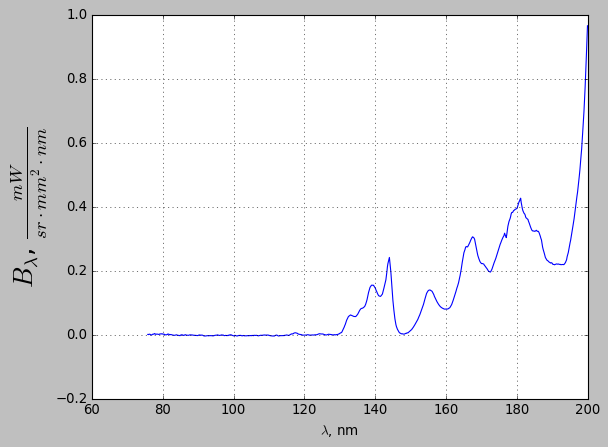

In [20]:
plt.style.use('classic')   # set plot style
plt.grid(True)

plt.plot(x_lambda[x_lambda <= 200], profile[x_lambda <= 200])
plt.xlabel('$\lambda$, nm')
plt.ylabel("$B_\lambda$, $\\frac{mW}{sr \cdot mm^2 \cdot nm}$", fontsize=24)

plt.show()

## График для средней мощности в единицу времени в пересчёте на эквивалентное число эффективных импульсов.

In [21]:
f = open("results.csv", "r")               # scan from another project
k = []
line = f.readline()
line = f.readline()
while line:
    tmp = line.rstrip().split(";")
    k += [float(tmp[4])/float(tmp[1])]
    line = f.readline()
f.close()

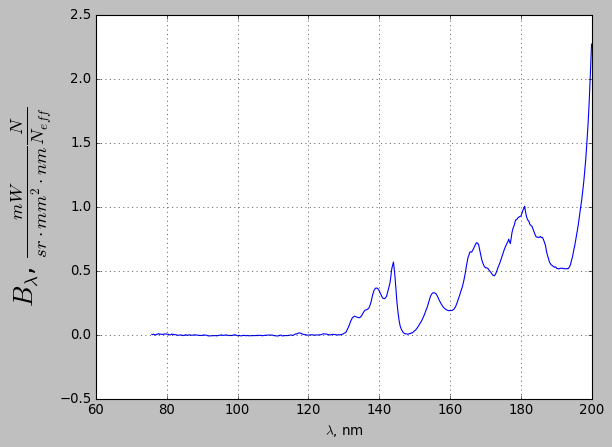

In [22]:
plt.style.use('classic')   # set plot style
plt.grid(True)

plt.plot(x_lambda[x_lambda <= 200], profile[x_lambda <= 200] / k)
plt.xlabel('$\lambda$, nm')
plt.ylabel("$B_\lambda$, $\\frac{mW}{sr \cdot mm^2 \cdot nm} \\frac{N}{N_{eff}}$", fontsize=24)

plt.show()